<a href="https://colab.research.google.com/github/BrouthenKamel/Auto-CL/blob/tests%2Famir%2Fcolor_stack/Rubik_Cube_ppo_AutoCL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install dependencies

In [1]:
!pip install -U dm-haiku

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 360.3/360.3 kB 5.2 MB/s eta 0:00:00


In [2]:
!pip install rlax jumanji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.7/131.7 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 583.5/583.5 kB 9.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.5/318.5 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 31.9 MB/s eta 0:00:00
  Created wheel for jumanji: filename=jumanji-0.3.1-py3-none-any.whl size=750375 sha256=2173757d274ca6c7b4c34de6a46406e1897af18989485019787b217df8affb35
  Stored in directory: /root/.cache/pip/wheels/31/29/10/884df072d319d2522cfff8b9c3d61fe60ab3c31e2a054d3e5d
Successfully built jumanji
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
  Attempting uninstall

# PPO

## Import

In [28]:
import jumanji
import jumanji.wrappers
from jumanji.environments.logic.rubiks_cube import generator as rubik_generator

import haiku as hk
import jax
from jax.nn import one_hot
import jax.numpy as jnp

import chex
import optax
import rlax
import distrax

import abc
from functools import partial
from typing import List, Callable
from pathlib import Path
from collections import deque
from collections.abc import Iterable

import matplotlib.pyplot as plt

import pickle
import numpy as np

import json

## Model

In [53]:
class DiscreteModel(hk.Module):

    def __init__(self, num_actions: int):
        super().__init__()
        self.num_actions = num_actions

    def __call__(self, observation):
        # print(f"[MODEL] Observation shape: {observation.shape}")

        if (len(observation.shape) == 4):
          x = hk.Conv2D(128, (2, 2), padding="SAME", stride=1)(observation)
          # x = hk.BatchNorm(create_scale=False, create_offset=False, decay_rate=0.99)(x, is_training=True)
          x = jax.nn.relu(x)
          # x = hk.MaxPool(window_shape=(2,2), padding="SAME", stride=1)
        else:
          print("why m I here")
          x = hk.Conv3D(128, (3, 2, 2), padding="SAME", stride=1)(observation)
          # x = hk.BatchNorm(create_scale=False, create_offset=False, decay_rate=0.99)(x, is_training=True)
          x = jax.nn.relu(x)
          # x = hk.MaxPool(window_shape=(2,2), padding="SAME", stride=1)
        x = hk.Flatten()(x)
        shared_params = hk.Sequential([
            hk.Linear(64), jax.nn.relu,
            hk.Linear(96), jax.nn.relu,
            hk.Linear(128), jax.nn.relu,
        ])(x)

        action_logtis = hk.Sequential([
            hk.Linear(96), jax.nn.relu,
            hk.Linear(64), jax.nn.relu,
            hk.Linear(self.num_actions)
        ])(shared_params)

        value = hk.Sequential([
            hk.Linear(96), jax.nn.relu,
            hk.Linear(64), jax.nn.relu,
            hk.Linear(1), jax.nn.tanh
        ])(shared_params)

        return action_logtis, value

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Utils

### Data classes

In [30]:
@chex.dataclass
class Transition:
    observation: chex.ArrayDevice
    action: int
    reward: float
    done: int
    next_observation: chex.ArrayDevice
    logits: chex.ArrayDevice
    log_pi: float
    state_value: chex.ArrayDevice
    advantage: float = None
    step_return: float = None


@chex.dataclass
class AgentState:
    params: hk.Params
    optimizer_state: optax.OptState


@chex.dataclass
class EpisodeStats:
    reward: int = 0
    num_steps: int = 0


@chex.dataclass
class TrainingStats:
    loss: float
    value_loss: float
    policy_loss: float
    entropy_loss: float

### Builders

In [31]:
class EpisodeStatsBuilder:

    def __init__(self):
        self._stats = EpisodeStats()

    def add(self, **kwargs):
        self._stats.num_steps += 1
        self._stats.reward += float(kwargs["reward"])

    def get(self):
        return self._stats

In [50]:
def make_agent_state(env, model_factory: hk.Module, lr: float, rng_key: chex.Array, device, strategy):
    with jax.default_device(device):
        init, apply = hk.without_apply_rng(hk.transform(model_factory))

        dummy_obs = env.reset()
        dummy_obs = refactor_obs(dummy_obs, strategy=strategy)

        params = init(rng=rng_key, x=dummy_obs[None, ...])

        optimizer = optax.adam(learning_rate=lr)
        optimizer_state = optimizer.init(params)

        return apply, optimizer.update, AgentState(params=params, optimizer_state=optimizer_state)

## Rollout

In [33]:
class RolloutBuffer:

    def __init__(self, batch_size: int, num_batches: int, discount_gamma: int, gae_lambda: int, use_gae: bool):
        self._transitions: List[Transition] = []
        self._discount_gamma = discount_gamma
        self._gae_lambda = gae_lambda
        self._batch_size = batch_size
        self._num_batches = num_batches
        self._use_gae = use_gae

    def reset(self):
        self._transitions = []

    def add(self, transition: Transition):
        if isinstance(transition, list):
            self._transitions.extend(transition)
        else:
            self._transitions.append(transition)

    @partial(jax.jit, static_argnums=0)
    def preprocess(self, rng_key, transitions):
        transitions = jax.tree_util.tree_map(lambda *t: jnp.asarray(t), *transitions)
        transitions.state_value = jax.lax.stop_gradient(transitions.state_value)

        discount_t = (1 - transitions.done) * self._discount_gamma

        if self._use_gae:
            extended_values = jnp.append(transitions.state_value, 0)
            transitions.advantage = rlax.truncated_generalized_advantage_estimation(
                r_t=transitions.reward,
                discount_t=discount_t,
                lambda_=self._gae_lambda,
                values=extended_values,
                stop_target_gradients=True
            )
            transitions.step_return = transitions.advantage + transitions.state_value
        else:
            transitions.step_return = rlax.discounted_returns(
                r_t=transitions.reward,
                discount_t=discount_t,
                v_t=0.0,
            )

            transitions.advantage = transitions.step_return - transitions.state_value

        transitions = jax.tree_util.tree_map(lambda t: jax.random.permutation(key=rng_key, x=t), transitions)
        transitions = jax.tree_util.tree_map(
            lambda t:
            t[:self._batch_size * self._num_batches].reshape(self._num_batches, self._batch_size, -1).squeeze(),
            transitions
        )

        transitions.observation = transitions.observation[:self._batch_size * self._num_batches].reshape(self._num_batches, self._batch_size, 6,3,3,6).squeeze()

        return transitions

    def get(self, rng_key):
        return self.preprocess(rng_key, self._transitions)

    def __len__(self):
        return len(self._transitions)


## Policy

### Base

In [34]:
class BasePPOPolicy(abc.ABC):

    def __init__(
            self,
            apply_fun: Callable,
            opt_update_fun: Callable,
            policy_clip: float,
            entropy_coefficient: float,
            value_coefficient: float,
            apply_value_clipping: bool = False,
            value_clip: int = 0.2
    ):
        self.apply_fun = apply_fun
        self._opt_update_fun = opt_update_fun
        self.policy_clip = policy_clip
        self.entropy_coefficient = entropy_coefficient
        self.value_coefficient = value_coefficient
        self._apply_value_clipping = apply_value_clipping
        self._value_clip = value_clip

    def get_importance_sampling_ratios(self, transitions, params):
        raise NotImplementedError()

    def get_entropy_loss(self, transitions, logits):
        raise NotImplementedError()

    def loss(self, params: hk.Params, transitions: Transition):
        ratio, new_logits, new_values = self.get_importance_sampling_ratios(transitions, params)

        advantage = jax.nn.standardize(transitions.advantage)

        policy_loss = rlax.clipped_surrogate_pg_loss(
            prob_ratios_t=ratio,
            adv_t=advantage,
            epsilon=self.policy_clip
        )

        targets = jax.nn.standardize(transitions.step_return)
        value_loss = rlax.l2_loss(
            predictions=jnp.squeeze(new_values),
            targets=targets
        )

        if self._apply_value_clipping:
            vf_clipped = transitions.state_value + jnp.clip(
                new_values - transitions.state_value,
                -self._value_clip,
                self._value_clip
            )

            value_loss_2 = rlax.l2_loss(
                predictions=jnp.squeeze(vf_clipped),
                targets=transitions.step_return
            )

            value_loss = jnp.minimum(value_loss, value_loss_2)

        value_loss = jnp.mean(value_loss)

        entropy_loss = self.get_entropy_loss(transitions, new_logits)

        loss_value = policy_loss + self.value_coefficient * value_loss + self.entropy_coefficient * entropy_loss

        return loss_value, (policy_loss, value_loss, entropy_loss)

    def update(self, transitions: Transition, agent_state: AgentState):
        (loss_value, (policy_loss, value_loss, entropy_loss)), grad = jax.value_and_grad(self.loss, has_aux=True)(
            agent_state.params, transitions
        )
        updates, new_opt_state = self._opt_update_fun(grad, agent_state.optimizer_state)
        new_params = optax.apply_updates(params=agent_state.params, updates=updates)

        training_stats = TrainingStats(
            loss=loss_value,
            policy_loss=policy_loss,
            value_loss=value_loss,
            entropy_loss=entropy_loss,
        )

        agent_state = AgentState(params=new_params, optimizer_state=new_opt_state)
        return agent_state, training_stats

    @abc.abstractmethod
    def act(self, observation: chex.ArrayNumpy, params: hk.Params, rng_key: chex.Array):
        pass

### discrete

In [35]:
class DiscretePPOPolicy(BasePPOPolicy):

    def get_importance_sampling_ratios(self, transitions, params):
        new_logits, new_values = self.apply_fun(params, transitions.observation)
        ratio = distrax.importance_sampling_ratios(
            target_dist=distrax.Categorical(new_logits),
            sampling_dist=distrax.Categorical(transitions.logits),
            event=transitions.action
        )
        return ratio, new_logits, new_values

    def get_entropy_loss(self, transitions, logits):
        return -jnp.mean(distrax.Softmax(logits).entropy())

    @partial(jax.jit, static_argnums=0)
    def act(self, observation: chex.ArrayNumpy, params: hk.Params, rng_key: chex.Array, explore=True):
        def sample(rng_key):
            return distribution.sample_and_log_prob(seed=rng_key)

        def deterministic_sample(*_):
            action = distribution.mode()
            log_pi = distribution.log_prob(action)

            return action, log_pi

        logits, state_value = self.apply_fun(params, observation[None, ...])
        logits, state_value = jnp.squeeze(logits), jnp.squeeze(state_value)

        distribution = distrax.Categorical(logits=logits)
        action, log_pi = jax.lax.cond(explore, true_fun=sample, false_fun=deterministic_sample, operand=rng_key)

        return action, logits, log_pi, state_value

# Trainer

In [36]:
class PPOTrainer:
    """
    The PPO trainer handles the evaluation and update loop of the PPO algorithm
    """

    def __init__(
            self,
            policy_class,
            env_factory: Callable,
            agent_state_factory: Callable,
            get_iter_level: Callable,
            get_max_iter_steps: Callable,
            num_iteration: int,
            num_sgd_iteration: int,
            learning_rate: float,
            policy_clip: float,
            entropy_coefficient: float,
            value_coefficient: float,
            batch_size: int,
            num_batches: int,
            discount_gamma: float,
            gae_lambda: float,
            value_clip: float,
            use_gae: bool,
            apply_value_clipping: bool,
            strategy: str,
            explore=True,
            deque_length=10,
            evaluation_device: str = "gpu",
            training_device: str = "gpu",
            checkpoint_freq: int = 25,
            cl_gen_freq: int = 25,
            checkpoint_dir: str = "checkpoints",
            render: bool = False,
    ):

        self._policy_cls = policy_class
        self._strategy = strategy
        self._env_factory = env_factory

        self._num_sgd_iteration = num_sgd_iteration
        self._num_iteration = num_iteration
        self._learning_rate = learning_rate
        self._batch_size = batch_size
        self._num_batches = num_batches
        self._discount_gamma = discount_gamma
        self._gae_lambda = gae_lambda
        self._policy_clip = policy_clip
        self._entropy_coefficient = entropy_coefficient
        self._value_coefficient = value_coefficient

        self._agent_state_factory = agent_state_factory
        self._cl_gen_freq = cl_gen_freq
        self._get_iter_level = get_iter_level
        self._get_max_iter_steps = get_max_iter_steps
        self._use_gae = use_gae
        self._apply_value_clipping = apply_value_clipping
        self._value_clip = value_clip

        self._explore = explore

        self._checkpoint_freq = checkpoint_freq
        self._checkpoint_dir = checkpoint_dir

        self._level = 1
        self._envs = {'1': self._env_factory(n_scrambles=self._level) }
        self._env =self._envs["1"]

        self._rewards = {
            "record": jnp.array([]),
            "reward_deque": deque(maxlen=deque_length)}

        self._eval_rewards = {
            "record": jnp.array([]),
            "reward_deque": deque(maxlen=deque_length)}

        self._losses = {
            "record" : {
                "loss": jnp.array([]),
                "value_loss": jnp.array([]),
                "entropy_loss": jnp.array([]),
                "policy_loss": jnp.array([])
            },
            "loss_deque" : {
                "loss": deque(maxlen=deque_length),
                "value_loss": deque(maxlen=deque_length),
                "entropy_loss": deque(maxlen=deque_length),
                "policy_loss": deque(maxlen=deque_length)
            }}

        self._render = render


        self._buffer = RolloutBuffer(
            discount_gamma=self._discount_gamma,
            gae_lambda=self._gae_lambda,
            batch_size=self._batch_size,
            num_batches=self._num_batches,
            use_gae=self._use_gae
        )
        [*_, self._train_device], [*_, self._eval_device] = jax.devices(training_device), jax.devices(evaluation_device)

    def _run_policy_evaluation(self, iteration, policy: BasePPOPolicy, agent_state: AgentState, seed: jnp.array, device):

        with jax.default_device(device):
            agent_state = jax.device_put(agent_state, device)
            self._buffer.reset()
            episodes_stats = []
            while len(self._buffer) < self._batch_size * self._num_batches:
                seed, episode_seed = jax.random.split(seed)
                transitions, episode_stats = self.run_single_episode(iteration, policy, agent_state, episode_seed, self._explore)
                self._buffer.add(transitions)
                episodes_stats.append(episode_stats)

            return self._buffer, episodes_stats

    def _run_policy_update(self, transitions, policy: BasePPOPolicy, agent_state: AgentState, device):

        @jax.jit
        def _train(agent_state, transitions):
            agent_state, training_stats = jax.lax.scan(
                f=lambda a, _: _train_single_iteration(a, transitions),
                init=agent_state,
                xs=jnp.arange(self._num_sgd_iteration)
            )
            training_stats = jax.tree_util.tree_map(lambda t: jnp.mean(t, axis=-1), training_stats)
            return agent_state, training_stats

        def _train_single_iteration(agent_state, transitions):
            agent_state, iteration_training_stats = jax.lax.scan(_train_single_batch, init=agent_state, xs=transitions)
            iteration_training_stats = jax.tree_util.tree_map(lambda t: jnp.mean(t, axis=-1), iteration_training_stats)
            return agent_state, iteration_training_stats

        def _train_single_batch(agent_state, transitions):
            agent_state, batch_training_stats = policy.update(transitions, agent_state)
            return agent_state, batch_training_stats

        with jax.default_device(device):
            transitions = jax.device_put(transitions, device)
            agent_state = jax.device_put(agent_state, device)
            agent_state, training_stats = _train(agent_state, transitions)

        return agent_state, training_stats


    def run_single_episode(self, iteration, policy, agent_state, seed, explore, render=False):

        observation = self._env.reset()
        observation = refactor_obs(observation, strategy=self._strategy)

        done = False
        i = 0
        transitions = []
        episode_stats_builder = EpisodeStatsBuilder()



        while not(done or i > self._get_max_iter_steps(self._level)):
            i += 1
            seed, step_seed = jax.random.split(seed)
            action, logits, log_pi, state_value = policy.act(observation, agent_state.params, step_seed,
                                                             explore=explore)

            action = jax.device_get(action)

            next_observation, reward, done, _ = self._env.step([action//3, 0, action%3])
            next_observation = refactor_obs(next_observation, strategy=self._strategy)

            transition = Transition(
                observation=observation,
                action=jnp.array(action),
                reward=jnp.array(reward),
                done=jnp.array(done),
                next_observation=next_observation,
                logits=jnp.array(logits),
                log_pi=log_pi,
                state_value=state_value
            )

            transitions.append(transition)
            episode_stats_builder.add(reward=reward)
            observation = next_observation
            if self._render:
                self._env.render()

        return transitions, episode_stats_builder.get()

    def run_rollouts(self, rng_key, num_episodes, render, checkpoint_dir=None):

        rng_key, params_seed = jax.random.split(rng_key)

        apply_fun, opt_update_fun, random_agent_state = self._agent_state_factory(
            env=self._env,
            lr=self._learning_rate,
            rng_key=params_seed,
            device=self._eval_device
        )

        if checkpoint_dir:
            agent_state = self._load_checkpoint(checkpoint_dir)
        else:
            agent_state = random_agent_state

        policy = self._policy_cls(
            apply_fun=apply_fun,
            opt_update_fun=opt_update_fun,
            policy_clip=self._policy_clip,
            entropy_coefficient=self._entropy_coefficient,
            value_coefficient=self._value_coefficient,
            apply_value_clipping=self._apply_value_clipping,
            value_clip=self._value_clip
        )

        for _ in range(num_episodes):
            rng_key, episode_seed = jax.random.split(rng_key)
            self.run_single_episode(policy, agent_state, render=render, seed=episode_seed, explore=False)

    def _update_env_level(self):
      if str(self._level) not in self._envs:
        self._envs[str(self._level)] = self._env_factory(n_scrambles=self._level)
        print(f'level: {self._level}')
      self._env = self._envs[str(self._level)]


    def train(self, rng_key):

        rng_key, params_seed = jax.random.split(rng_key)
        apply_fun, opt_update_fun, self._agent_state = self._agent_state_factory(
            env=self._env,
            lr=self._learning_rate,
            rng_key=params_seed,
            device=self._eval_device,
            strategy = self._strategy
            )

        self._policy = self._policy_cls(
            apply_fun=apply_fun,
            opt_update_fun=opt_update_fun,
            policy_clip=self._policy_clip,
            entropy_coefficient=self._entropy_coefficient,
            value_coefficient=self._value_coefficient,
            apply_value_clipping=self._apply_value_clipping,
            value_clip=self._value_clip)

        #init
        iter_mean_reward = 0
        for iter in range(self._num_iteration):
            if iter % self._cl_gen_freq == 0:
              self._level = self._get_iter_level(iter, iter_mean_reward)
              self._update_env_level()


            rng_key, iteration_seed = jax.random.split(rng_key)
            buffer, episodes_stats = self._run_policy_evaluation(
                iter,
                self._policy,
                self._agent_state,
                seed=iteration_seed,
                device=self._eval_device
            )

            iter_mean_reward = jnp.array([x.reward for x in episodes_stats]).mean()

            self._rewards["reward_deque"].append(iter_mean_reward)
            temp_deque = jnp.array(list(self._rewards["reward_deque"]))
            self._rewards["record"] = jnp.append(self._rewards["record"], temp_deque.mean())

            if (iter+1) % self._checkpoint_freq == 0:
              print(f"Iteration {iter+1}...")
              print(f"Iteration mean reward: {iter_mean_reward:.2f}")

            transitions = buffer.get(iteration_seed)

            # TO DO: make transition selection

            self._agent_state, training_stats = self._run_policy_update(
                transitions,
                self._policy,
                self._agent_state,
                self._train_device
            )

            del transitions
            del episodes_stats

            for loss_name in ["loss", "value_loss", "entropy_loss", "policy_loss"]:
              self._losses["loss_deque"][loss_name].append(training_stats[loss_name])
              temp_deque = jnp.array(list(self._losses["loss_deque"][loss_name]))
              self._losses["record"][loss_name] = jnp.append(self._losses["record"][loss_name], temp_deque.mean())

            del training_stats

            del temp_deque

    def eval(self, rng_key,num_iter, eval_level_gen_freq, get_eval_iter_level):

        for iter in range(num_iter):
            if iter % eval_level_gen_freq == 0:
              self._level = get_eval_iter_level(iter)
              self._update_env_level()


            rng_key, iteration_seed = jax.random.split(rng_key)
            buffer, episodes_stats = self._run_policy_evaluation(
              iter,
              self._policy,
              self._agent_state,
              seed=iteration_seed,
              device=self._eval_device
            )

            iter_mean_reward = jnp.array([x.reward for x in episodes_stats]).mean()

            self._eval_rewards["reward_deque"].append(iter_mean_reward)
            temp_deque = jnp.array(list(self._eval_rewards["reward_deque"]))
            self._eval_rewards["record"] = jnp.append(self._eval_rewards["record"], temp_deque.mean())

            if (iter+1) % self._checkpoint_freq == 0:
              print(f"Iteration {iter+1}...")
              print(f"Iteration mean reward: {iter_mean_reward:.2f}")

    def get_record(self):
      return self._rewards["record"], self._losses["record"]


    def get_eval_record(self):
      return self._eval_rewards["record"]

    def set_max_iter_steps(self, max_iter_steps):
      self._max_iter_steps = max_iter_steps

    def set_n_scrambles(self, n_scrambles):
      self._n_scrambles = n_scrambles

# Utilities

##env Utilities

In [37]:
def make_env(n_scrambles=5):
  partly_scrambled_rubiks_cube_generator = rubik_generator.ScramblingGenerator(
    cube_size=3, num_scrambles_on_reset=n_scrambles )

  env = jumanji.make("RubiksCube-v0", generator=partly_scrambled_rubiks_cube_generator)
  env = jumanji.wrappers.JumanjiToGymWrapper(env)
  return env

def get_action_space(env):
  dim = 1
  for i in env.action_space.nvec:
    dim *= i
  return dim

In [38]:
def _make_agent_state(env, lr: float, rng_key: chex.Array, device, strategy):
    action_space = get_action_space(env)
    model_factory = lambda x: DiscreteModel(num_actions=action_space)(x)
    return make_agent_state(env, model_factory=model_factory, lr=lr, rng_key=rng_key, device=device, strategy=strategy)

In [61]:
def refactor_obs(obs, strategy="stack_colors"):
  if strategy=="one_hot":
    return one_hot(obs['cube'].astype(jnp.float32), 6)
  elif strategy=="label":
    return obs['cube'].astype(jnp.float32).transpose((1, 2, 0))
  elif strategy=="gray_scale":
    return obs['cube'].astype(jnp.float32).transpose((1, 2, 0)) / 5
  elif strategy=="stack_faces":
    return one_hot(obs['cube'].astype(jnp.float32), 6).reshape((18,3,6))
  elif strategy=="stack_colors":
    return one_hot(obs['cube'].astype(jnp.float32), 6).transpose((3,1,2,0)).reshape((18,3,6))

##Plot Utilities

In [40]:
def plot_rewards(rewards, lessons, figsize=(12, 5)):
    iterations = range(len(rewards))

    plt.figure(figsize=figsize)
    plt.ylim(0.0, 5.0)
    plt.ylabel('nb Scrambles')
    plt.bar([x*25 +10 for x in range(len(lessons))], lessons, width=20.0, color='orange')

    axes2 = plt.twinx()
    axes2.set_ylim(0.0, 1.0)
    axes2.plot(iterations, rewards)

    axes2.set_xlabel('Iterations')
    axes2.set_ylabel('Mean rewards')
    plt.title("Solving Rubik's cube")

    plt.show()

In [41]:
def plot_losses(losses, figsize=(16, 8)):
    iterations = range(len(losses["loss"]))

    plt.figure(figsize=figsize)
    fig, axes = plt.subplots(2, 2, figsize=figsize)

    for i, split in enumerate(losses.keys()):
      axes[i//2, i%2].plot(iterations, losses[split])
      axes[i//2, i%2].set_title(f"{split} plot")

    plt.tight_layout()
    plt.show()

In [42]:
def display_time(start, end):
  duration = end - start
  print(f"Training took {(duration // 60)} minutes and {round(duration % 60)} seconds!")

##Save Utils

In [43]:
def save_record(file_name, rewards, losses, curriculum= []):
  with open(f'/content/{file_name}.json', 'w') as f:
    json.dump({
        "rewards": rewards,
        "losses": losses,
        'curriculum': curriculum
    }, f, indent=4)

In [44]:
def load_record(file_name):
  with open(f'/content/{file_name}.json') as f:
    record = json.load(f)

  return record["rewards"], record["losses"], record['curriculum']

In [45]:
def listify(jnp_array):
  return [float(i) for i in jnp_array]

# AUTO-CL

In [55]:
class StudentEnv:
  def __init__(self,
               teacher,
               action_space : int = 5
               ):
    self._teacher = teacher

    #init
    self._training_record = deque()
    self._task_reward_buffer = {}
    self._current_action = 1

    for action in range(1, action_space +1):
      self._task_reward_buffer[str(action)] =deque([0])

  def get_iter_level(self,iter, stats):
    #remember latest action
    action = self._current_action
    reward, obs = self.reward(action = action, stats = stats), self.observation(action = action, stats = stats)

    #record the action, reward, obs
    self.record(action, reward, obs)

    #get the next step from the Teacher
    step = self._teacher.act_according(action, reward, obs)
    self._current_action = step
    return step

  def reward(self, action, stats):
    return abs(self._task_reward_buffer[str(action)][-1] - stats)


  def observation(self, action: int, stats):
    return stats


  def record(self, action: int, reward, obs):
    self._task_reward_buffer[str(action)].append(obs) #obs is the mean reward of student
    self._training_record.append([action, reward, obs]) #reward is the teacher reward


  def step(self, action):
    pass


  def reset(self):
    pass

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [56]:
class Teacher:
  def __init__(self, action_space):
    self._action_space = action_space


  def act_according(self, action, reward, obs):
    #update policy
    self.policy_update(action, reward, obs)

    #get next lesson
    action = self.step()
    return action

  def policy_update(self, action, reward, obs):
    raise NotImplementedError

  def step(self):
    raise NotImplementedError



In [59]:
class OnlineTeacher(Teacher):
  def __init__(self, action_space, alpha, epsilon):
    super(OnlineTeacher, self).__init__( action_space)
    self._alpha = alpha
    self._epsilon = epsilon
    self._return_record = deque()
    self._return = jnp.zeros(self._action_space)

  def policy_update(self, action, reward, obs):
    #updated reward
    Q = self._return.at[action -1].get()
    Q_new = self._alpha*reward + (1-self._alpha)*Q

    print(f'REWARD:{reward}')
    # print(f'Q_new:{Q_new}')
    #add to retrun vector
    self._return = self._return.at[action -1].set(Q_new)
    #add to record
    self._return_record.append(self._return)

  def step(self):
    p = np.random.random()
    if p < self._epsilon:
      action = np.random.choice(self._action_space)
    else:
      action = jnp.argmax(self._return)
    action = action+1
    print(f'RETURN: {self._return}')
    print(f'STEP:{action}')
    return action

  def get_record(self):
    return self._return_record

# Auto CL test

In [64]:
rng_key = jax.random.PRNGKey(10)

teacher = OnlineTeacher(action_space = 5, alpha = 0.9, epsilon = 0.3)

student_env = StudentEnv(teacher = teacher, action_space = 5)

rng_key = jax.random.PRNGKey(10)
print(rng_key)
ppo_trainer = PPOTrainer(
  policy_class=DiscretePPOPolicy,
  env_factory=make_env,
  agent_state_factory=_make_agent_state,
  get_iter_level = student_env.get_iter_level, #environment method
  get_max_iter_steps = lambda x: x+2 if x<5 else x+3, #nb scrambles +2 for 1..4 and +3 for 5..
  cl_gen_freq=25, #check for change in level each 10 iter
  num_iteration=1500,
  num_sgd_iteration=8,
  learning_rate=0.0001,
  policy_clip=0.2,
  entropy_coefficient=0.05,
  value_coefficient=1.0,
  batch_size=128,
  num_batches=4,
  discount_gamma=0.99,
  gae_lambda=0.95,
  value_clip=0.1,
  use_gae=True,
  apply_value_clipping=True,
  checkpoint_freq=25,
  deque_length=10,
  render=False,
  strategy="stack_colors"
)


ppo_trainer.train(rng_key)
rewards, losses = ppo_trainer.get_record()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[ 0 10]
REWARD:0
RETURN: [0. 0. 0. 0. 0.]
STEP:1
why m I here


ValueError: ignored

In [ ]:
levels = [record[0] for record in student_env._training_record]
print(levels)

[1, Array(1, dtype=int32), 3, 2, Array(2, dtype=int32), 4, Array(1, dtype=int32), Array(1, dtype=int32), Array(2, dtype=int32), Array(2, dtype=int32), Array(4, dtype=int32), Array(4, dtype=int32), 1, 4, Array(3, dtype=int32), 4, Array(3, dtype=int32), Array(3, dtype=int32), 5, Array(5, dtype=int32), Array(3, dtype=int32), Array(3, dtype=int32), Array(2, dtype=int32), 5, Array(5, dtype=int32), Array(5, dtype=int32), Array(5, dtype=int32), 5, Array(5, dtype=int32), 1, Array(5, dtype=int32), Array(5, dtype=int32), 2, Array(4, dtype=int32), Array(5, dtype=int32), 2, Array(2, dtype=int32), Array(3, dtype=int32), 2, Array(3, dtype=int32), Array(3, dtype=int32), 4, Array(4, dtype=int32), 2, Array(4, dtype=int32), 2, Array(4, dtype=int32), Array(3, dtype=int32), 5, Array(5, dtype=int32), Array(5, dtype=int32), 4, Array(2, dtype=int32), Array(3, dtype=int32), Array(4, dtype=int32), 5, 5, 3, 3, Array(5, dtype=int32)]


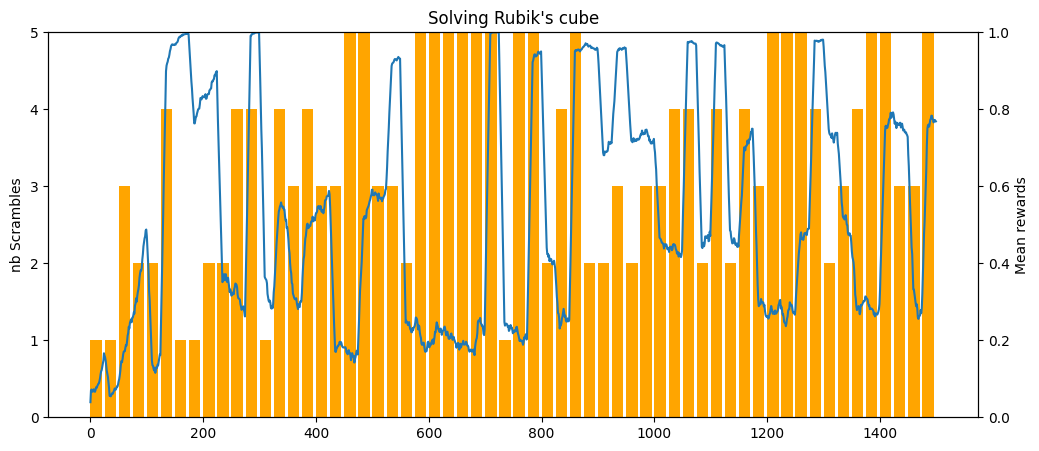

In [ ]:
plot_rewards(rewards, levels)

In [ ]:
rng_key = jax.random.PRNGKey(10)
ppo_trainer.eval(rng_key,num_iter=250, eval_level_gen_freq=50, get_eval_iter_level= lambda x: x//50 +1)
eval_rewards = ppo_trainer.get_eval_record()

Iteration 25...
Iteration mean reward: 1.00
Iteration 50...
Iteration mean reward: 1.00
Iteration 75...
Iteration mean reward: 0.97
Iteration 100...
Iteration mean reward: 0.96
Iteration 125...
Iteration mean reward: 0.82
Iteration 150...
Iteration mean reward: 0.76
Iteration 175...
Iteration mean reward: 0.59
Iteration 200...
Iteration mean reward: 0.57
Iteration 225...
Iteration mean reward: 0.19
Iteration 250...
Iteration mean reward: 0.31


In [ ]:
np.save('eval_rewards_1500',eval_rewards)

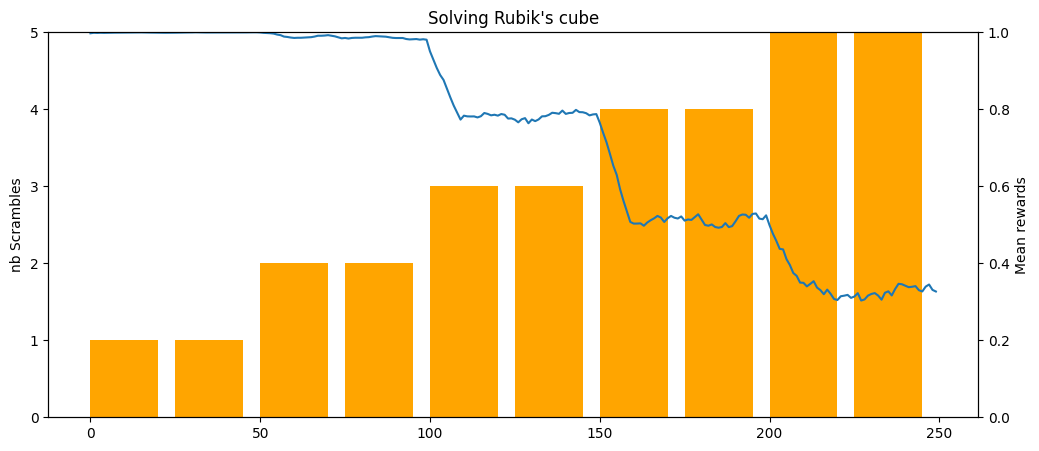

In [ ]:
plot_rewards(eval_rewards, [1, 1,2, 2,3, 3,4, 4, 5, 5])

In [ ]:
#load previous rewards
losses_800 = np.load(losses_cl.npy)
rewards_800 = np.load(rewards_cl.npy)

<Figure size 1600x800 with 0 Axes>

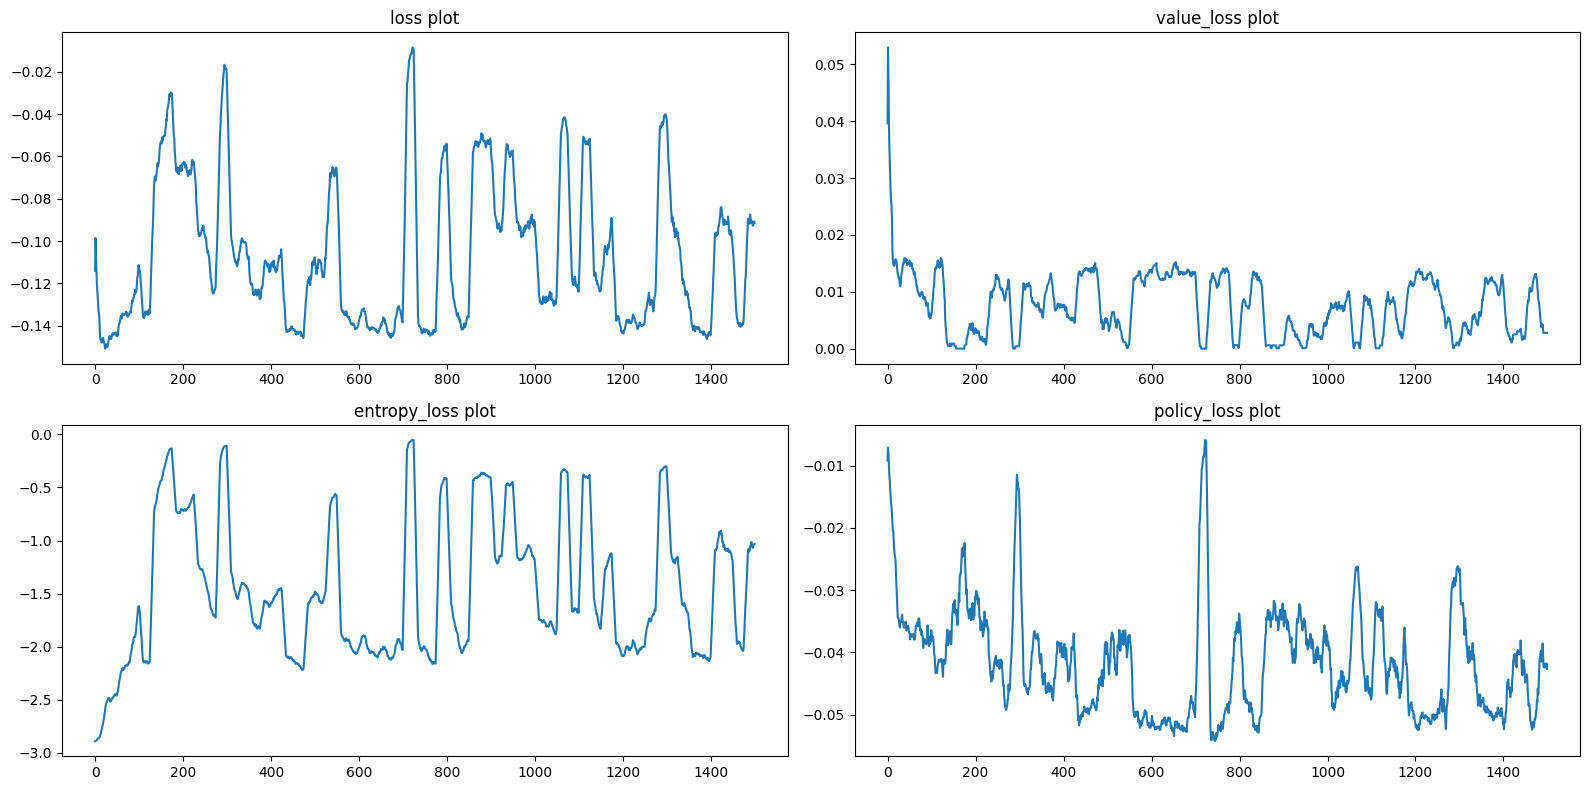

In [ ]:
plot_losses(losses)

In [ ]:
np.save('rewards_cl', rewards)
np.save('losses_cl', losses)
np.save('student_task_reward_buffer', student_env._task_reward_buffer)
np.save('student_training_record', student_env._training_record)

# Training Test

In [ ]:
rng_key = jax.random.PRNGKey(10)
ppo_trainer22 = PPOTrainer(
  policy_class=DiscretePPOPolicy,
  env_factory=make_env,
  agent_state_factory=_make_agent_state,
  get_iter_level = lambda x: x//200 +1, #each level for 200 iter
  get_max_iter_steps = lambda x: x+2, #nb scrambles +2
  cl_gen_freq=25, #check for change in level each 25 iter
  num_iteration=600,
  num_sgd_iteration=8,
  learning_rate=0.0001,
  policy_clip=0.2,
  entropy_coefficient=0.05,
  value_coefficient=1.0,
  batch_size=100,
  num_batches=4,
  discount_gamma=0.99,
  gae_lambda=0.95,
  value_clip=0.1,
  use_gae=True,
  apply_value_clipping=True,
  checkpoint_freq=25,
  deque_length=10,
  render=False,
)

ppo_trainer.train(rng_key)
rewards, losses = ppo_trainer.get_record()

NameError: ignored

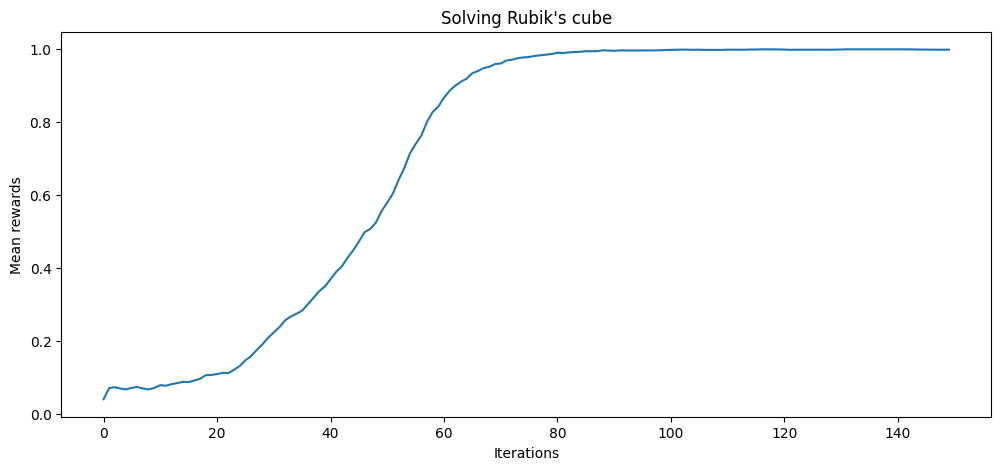

In [ ]:
plot_rewards(rewards)

<Figure size 1600x800 with 0 Axes>

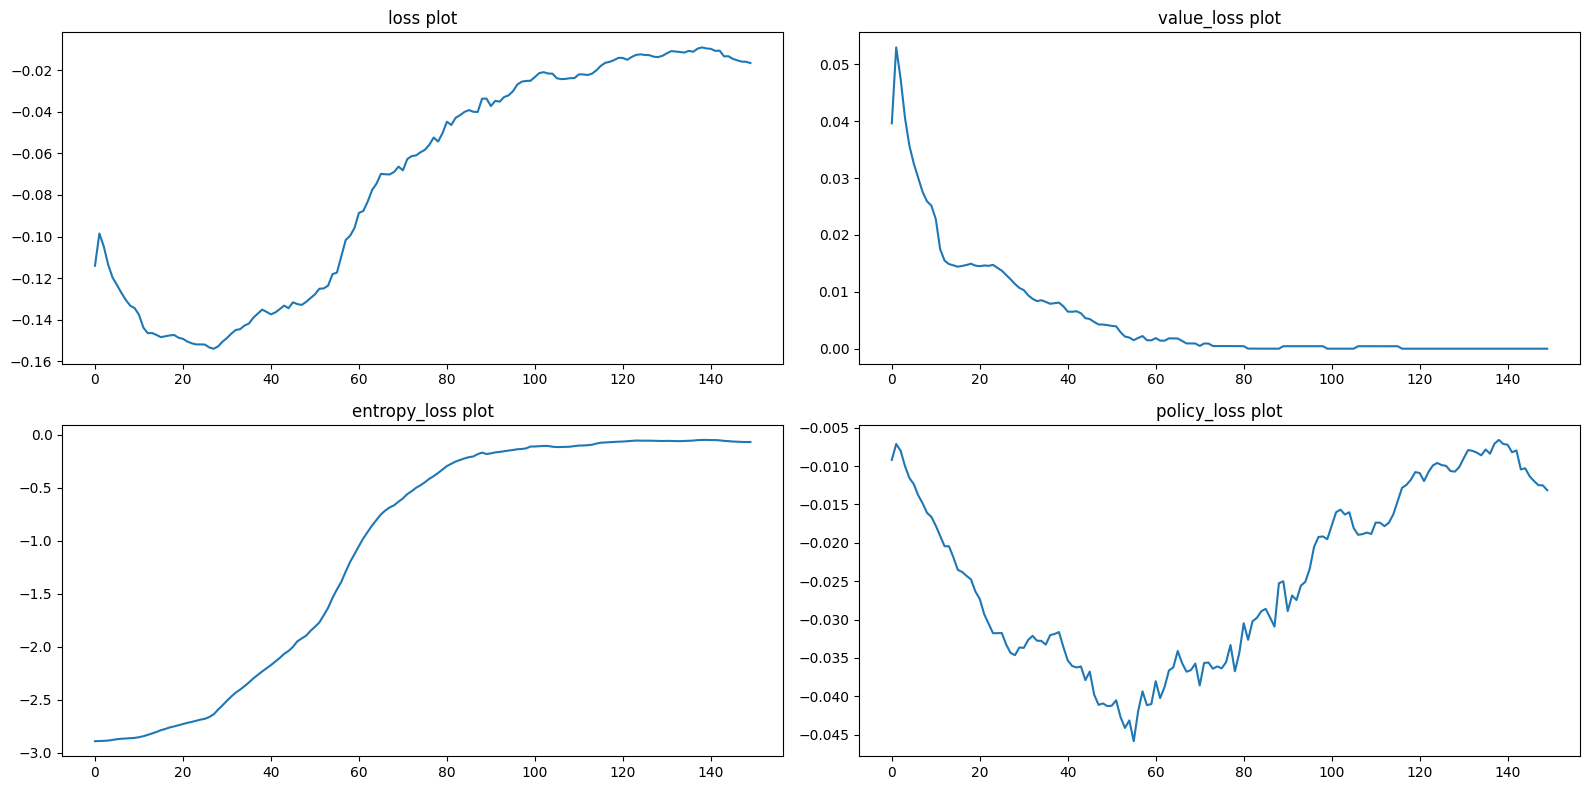

In [ ]:
plot_losses(losses)

# Train

In [ ]:
def train_n_scrambled_cube(n_scrambles, num_iteration, max_iter_steps, seed=10, checkpoint=25):
  rng_key = jax.random.PRNGKey(seed)
  if (isinstance(n_scrambles, int)):
    print(f"[INFO] Training on {n_scrambles} scrambled Rubik's cube")
  else:
    print(f"[INFO] Training on multi-steps scrambled Rubik's cube")
  ppo_trainer = PPOTrainer(
    policy_class=DiscretePPOPolicy,
    env_factory=make_env,
    agent_state_factory=_make_agent_state,
    num_iteration=num_iteration,
    num_sgd_iteration=8,
    learning_rate=0.0001,
    policy_clip=0.2,
    entropy_coefficient=0.05,
    value_coefficient=1.0,
    batch_size=100,
    num_batches=4,
    discount_gamma=0.99,
    gae_lambda=0.95,
    value_clip=0.1,
    use_gae=True,
    apply_value_clipping=True,
    checkpoint_freq=checkpoint,
    deque_length=10,
    max_iter_steps=max_iter_steps,
    render=False,
    n_scrambles_param=n_scrambles
  )
  ppo_trainer.train(rng_key)

  if (isinstance(n_scrambles, int)):
    print(f"[INFO] Finished Training on {n_scrambles} scrambled Rubik's cube")
  else:
    print(f"[INFO] Finished Training on multi-steps scrambled Rubik's cube")

  return ppo_trainer

# Multiple steps scrambled cubes

## 1 time scramble

In [ ]:
trainer_1 = train_n_scrambled_cube(n_scrambles=1, num_iteration=300, max_iter_steps=5)
rewards_1, losses_1 = trainer_1.get_record()

[INFO] Training on 1 scrambled Rubik's cube
Iteration 50...
Iteration mean reward: 0.71
Iteration 100...
Iteration mean reward: 1.00
Iteration 150...
Iteration mean reward: 0.99
Iteration 200...
Iteration mean reward: 0.95
Iteration 250...
Iteration mean reward: 0.99
Iteration 300...
Iteration mean reward: 0.99
[INFO] Finished 1 scrambled Rubik's cube


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


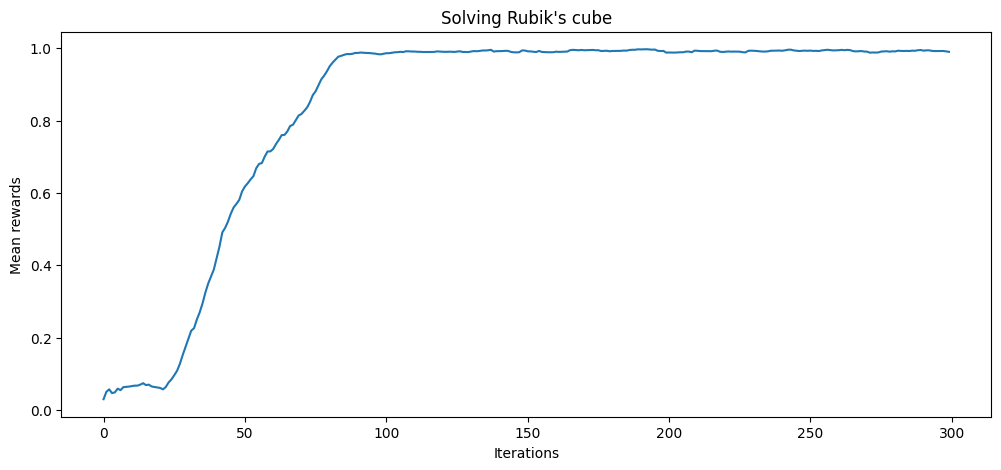

In [ ]:
plot_rewards(rewards_1)

<Figure size 1600x800 with 0 Axes>

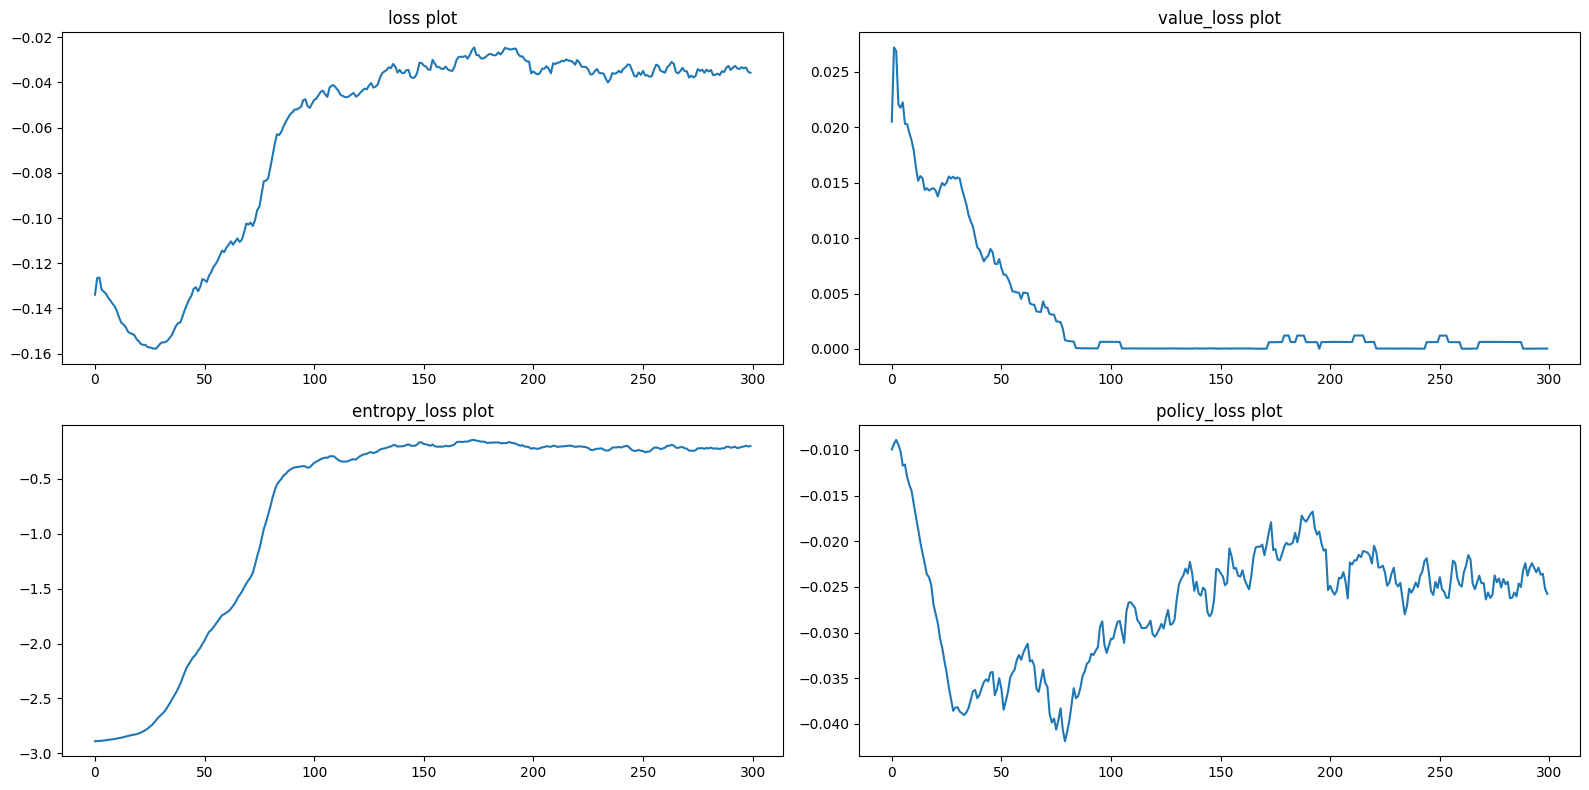

In [ ]:
plot_losses(losses_1)

## 2 times scramble

In [ ]:
trainer_2 = train_n_scrambled_cube(n_scrambles=2, num_iteration=300, max_iter_steps=5)
rewards_2, losses_2 = trainer_2.get_record()

[INFO] Training on 2 scrambled Rubik's cube
Iteration 50...
Iteration mean reward: 0.14
Iteration 100...
Iteration mean reward: 0.23
Iteration 150...
Iteration mean reward: 0.36
Iteration 200...
Iteration mean reward: 0.65
Iteration 250...
Iteration mean reward: 0.70
Iteration 300...
Iteration mean reward: 0.79
[INFO] Finished 2 scrambled Rubik's cube


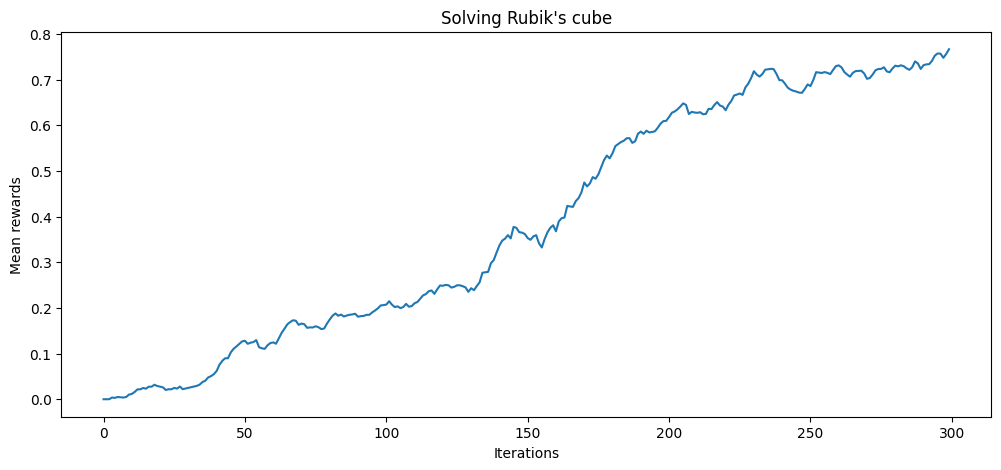

In [ ]:
plot_rewards(rewards_2)

<Figure size 1600x800 with 0 Axes>

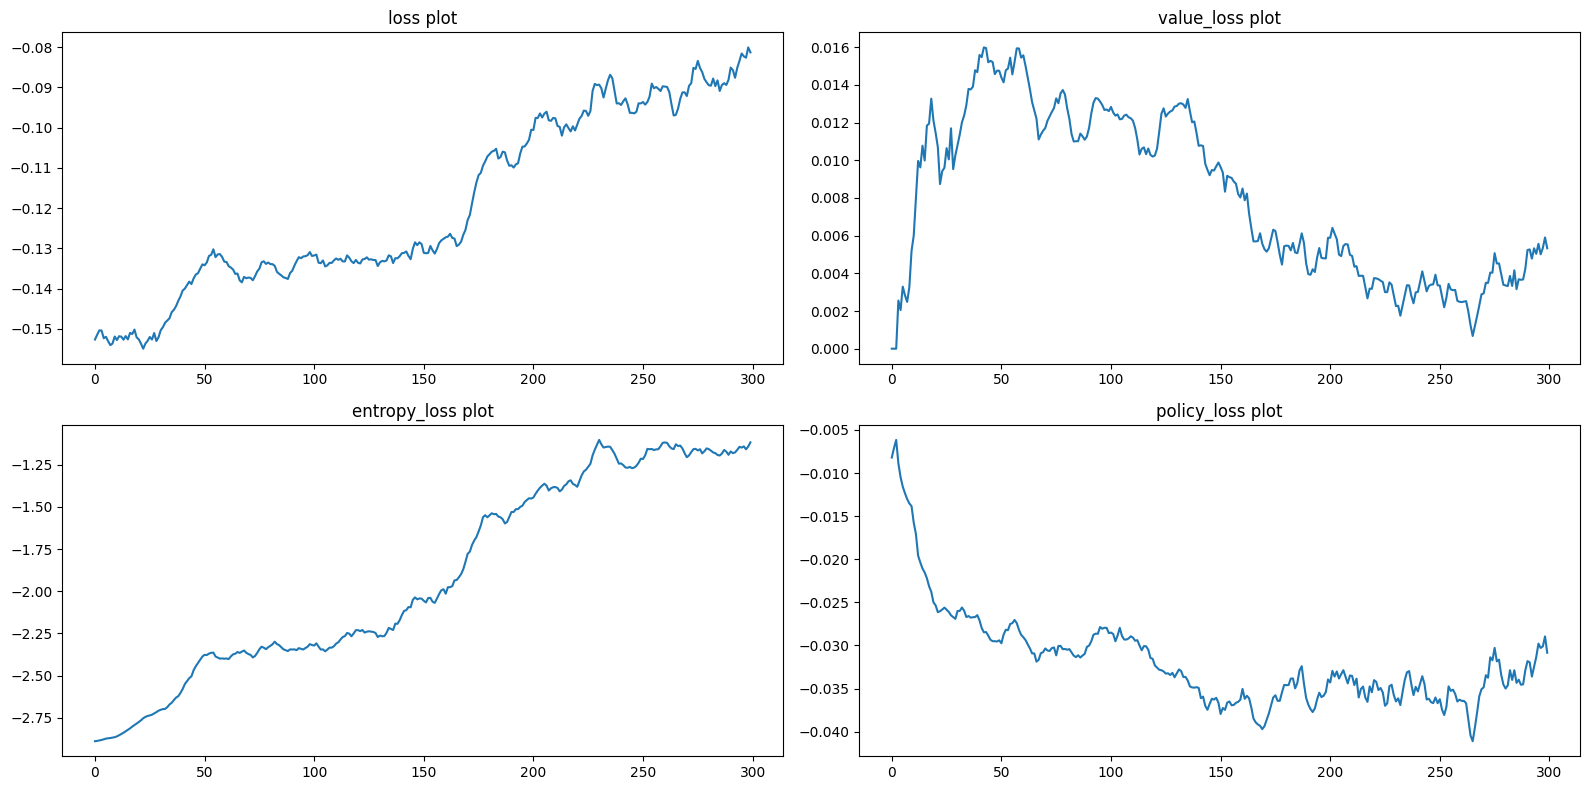

In [ ]:
plot_losses(losses_2)

## 3 times scramble

In [ ]:
trainer_3 = train_n_scrambled_cube(n_scrambles=3, num_iteration=300, max_iter_steps=5)
rewards_3, losses_3 = trainer_3.get_record()

[INFO] Training on 3 scrambled Rubik's cube
Iteration 50...
Iteration mean reward: 0.04
Iteration 100...
Iteration mean reward: 0.11
Iteration 150...
Iteration mean reward: 0.09
Iteration 200...
Iteration mean reward: 0.35
Iteration 250...
Iteration mean reward: 0.32
Iteration 300...
Iteration mean reward: 0.35
[INFO] Finished 3 scrambled Rubik's cube


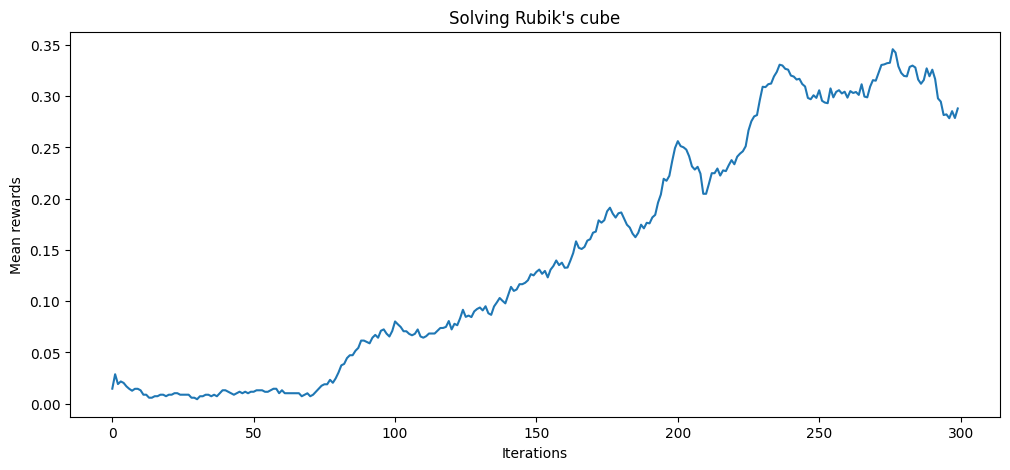

In [ ]:
plot_rewards(rewards_3)

<Figure size 1600x800 with 0 Axes>

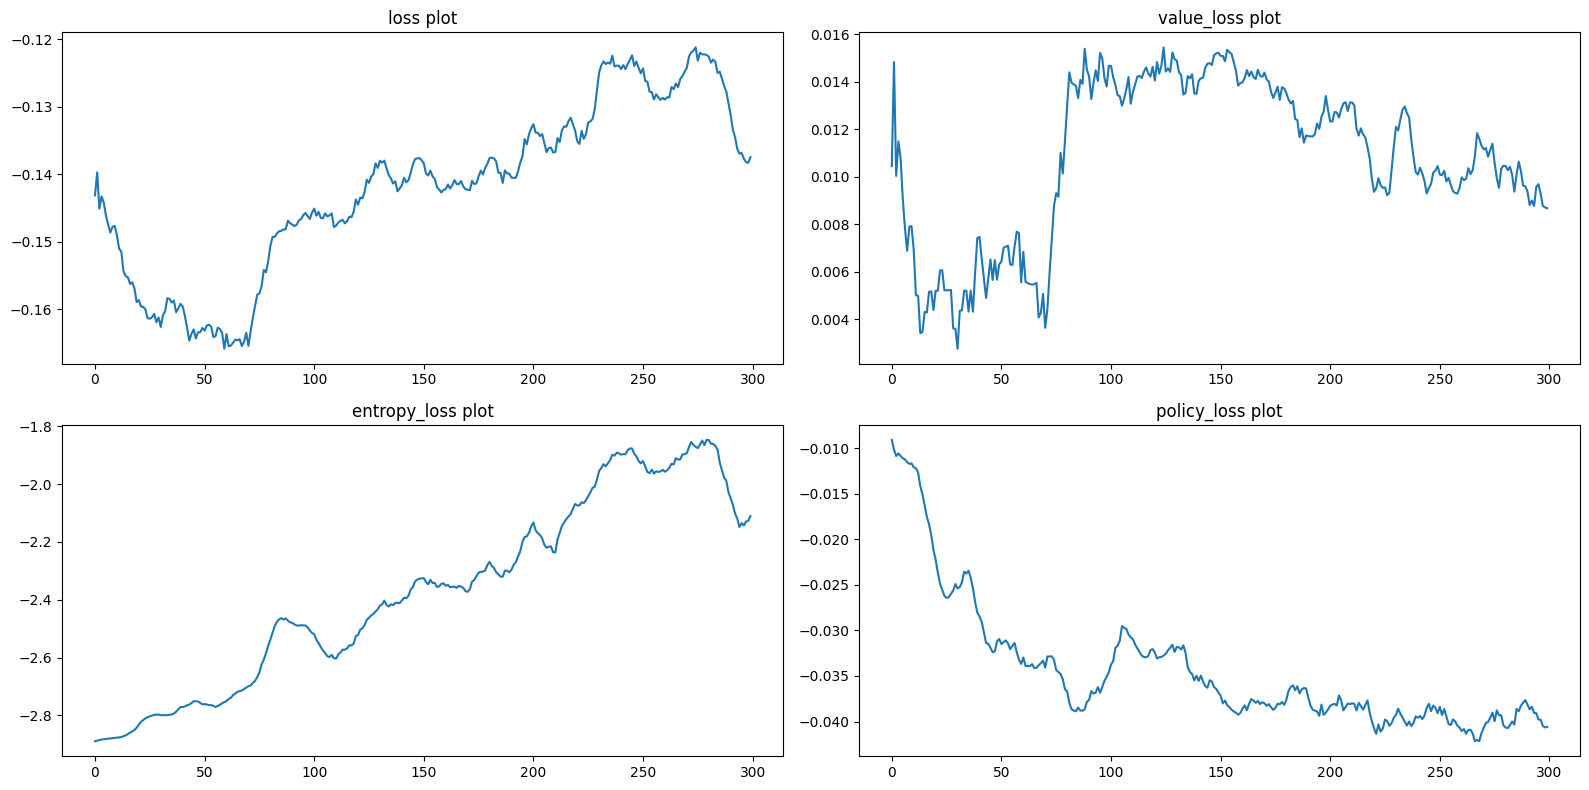

In [ ]:
plot_losses(losses_3)

## 5 times scramble

In [ ]:
trainer_5 = train_n_scrambled_cube(n_scrambles=5, num_iteration=1000, max_iter_steps=8, checkpoint=50)
rewards_5, losses_5 = trainer_5.get_record()

[INFO] Training on 5 scrambled Rubik's cube
Iteration 50...
Iteration mean reward: 0.00
Iteration 100...
Iteration mean reward: 0.00
Iteration 150...
Iteration mean reward: 0.00
Iteration 200...
Iteration mean reward: 0.00
Iteration 250...
Iteration mean reward: 0.00
Iteration 300...
Iteration mean reward: 0.00
Iteration 350...
Iteration mean reward: 0.00
Iteration 400...
Iteration mean reward: 0.00
Iteration 450...
Iteration mean reward: 0.00
Iteration 500...
Iteration mean reward: 0.00
Iteration 550...
Iteration mean reward: 0.00
Iteration 600...
Iteration mean reward: 0.00
Iteration 650...
Iteration mean reward: 0.00
Iteration 700...
Iteration mean reward: 0.00
Iteration 750...
Iteration mean reward: 0.00
Iteration 800...
Iteration mean reward: 0.02
Iteration 850...
Iteration mean reward: 0.00
Iteration 900...
Iteration mean reward: 0.00
Iteration 950...
Iteration mean reward: 0.00
Iteration 1000...
Iteration mean reward: 0.00
[INFO] Finished Training on 5 scrambled Rubik's cube


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


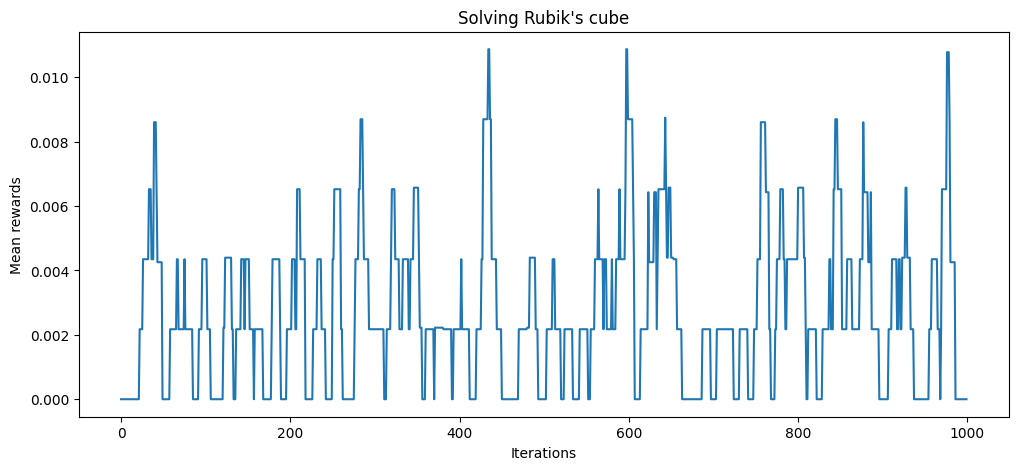

In [ ]:
plot_rewards(rewards_5)

<Figure size 1600x800 with 0 Axes>

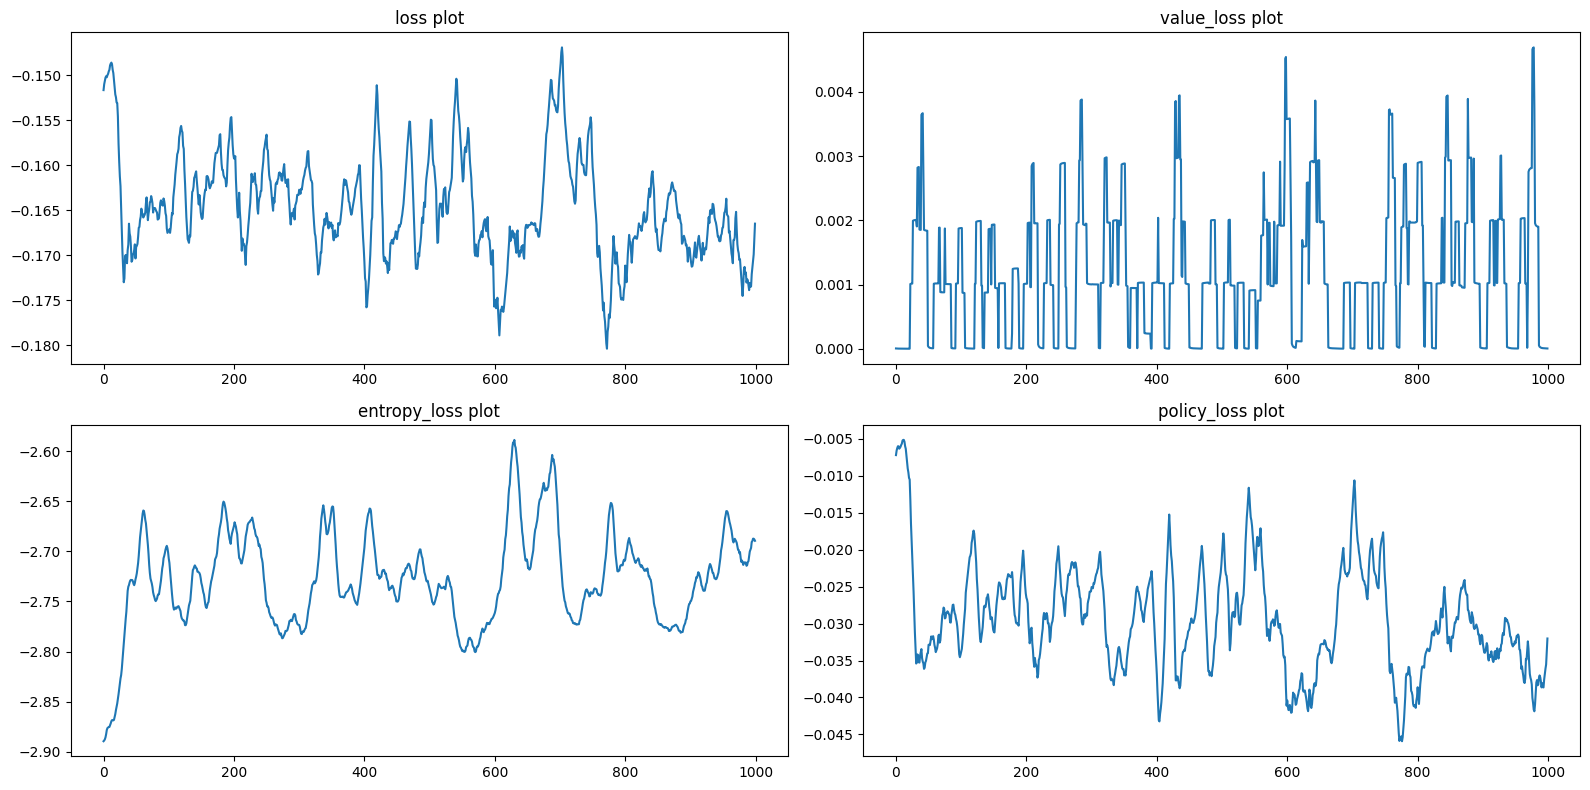

In [ ]:
plot_losses(losses_5)

## Comaparative evaluation

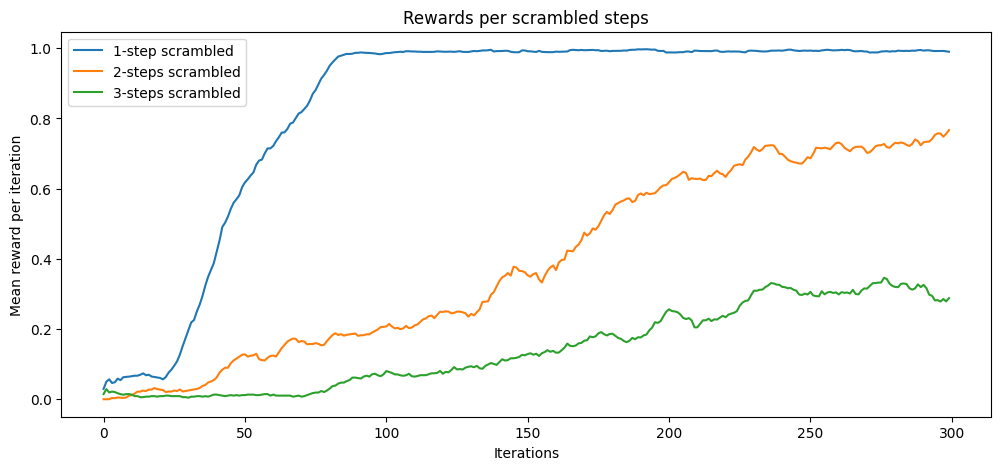

In [ ]:
iterations = range(len(rewards_1))

plt.figure(figsize=(12, 5))

plt.plot(iterations, rewards_1, label='1-step scrambled')
plt.plot(iterations, rewards_2, label='2-steps scrambled')
plt.plot(iterations, rewards_3, label='3-steps scrambled')

plt.xlabel('Iterations')
plt.ylabel('Mean reward per iteration')
plt.title('Rewards per scrambled steps')
plt.legend()

plt.show()

<Figure size 2000x800 with 0 Axes>

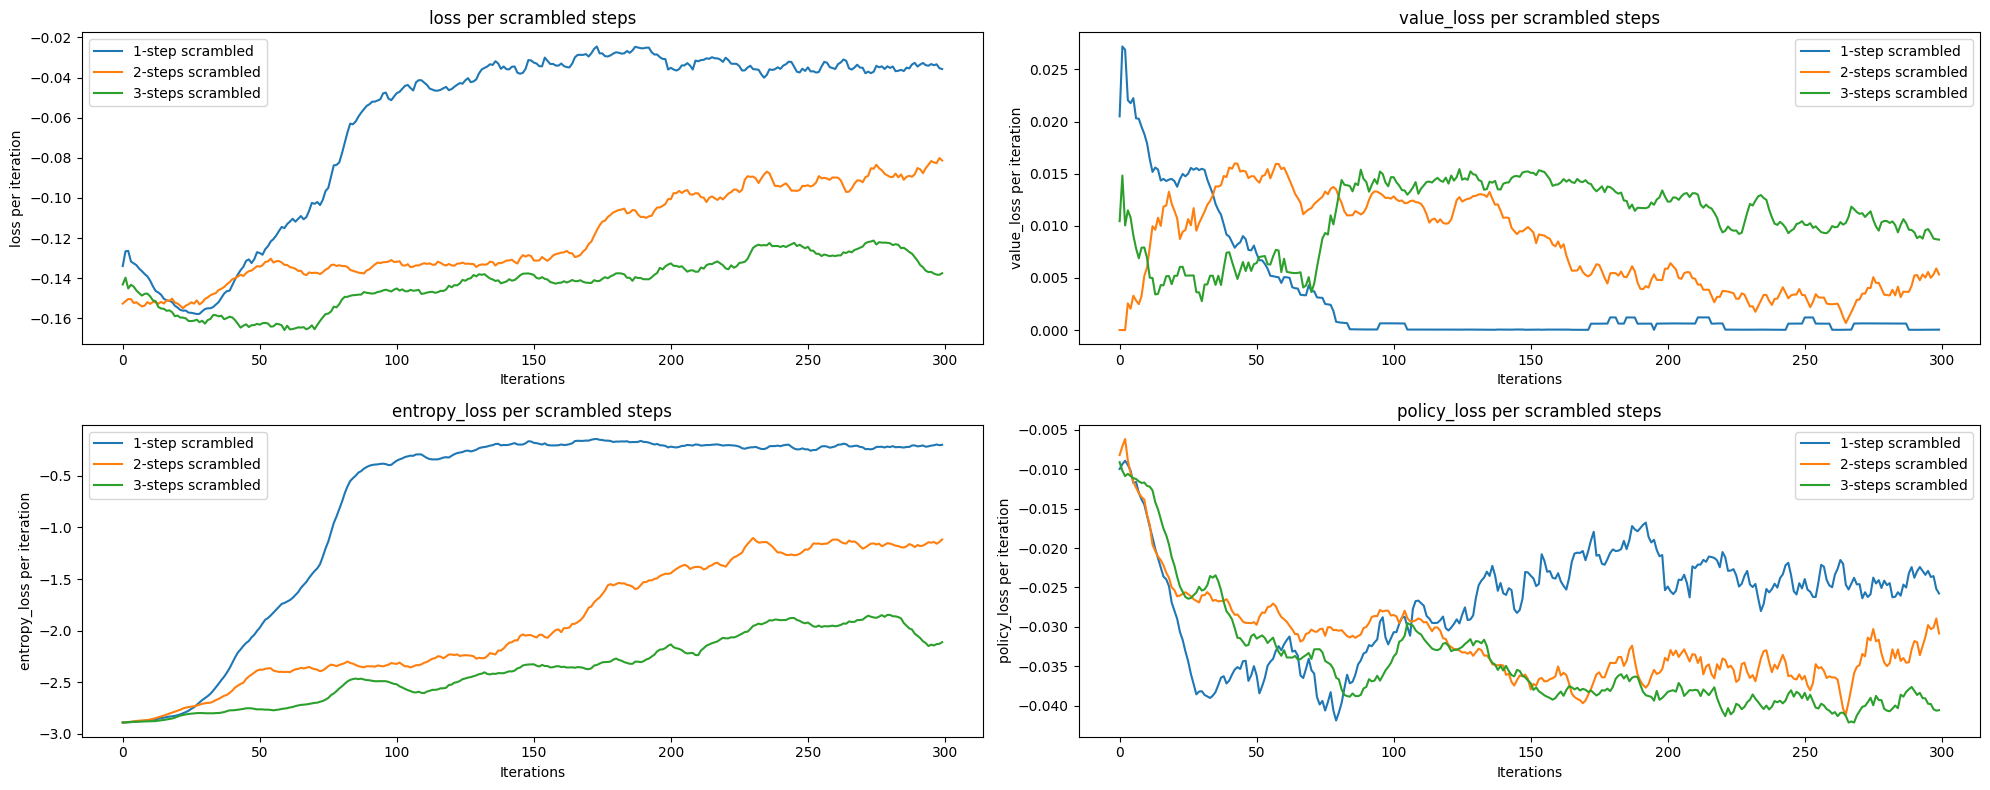

In [ ]:
iterations = range(len(losses_1['loss']))
figsize = (20, 8)

plt.figure(figsize=figsize)
fig, axes = plt.subplots(2, 2, figsize=figsize)

for i, split in enumerate(losses_1.keys()):
  axes[i//2, i%2].plot(iterations, losses_1[split], label='1-step scrambled')
  axes[i//2, i%2].plot(iterations, losses_2[split], label='2-steps scrambled')
  axes[i//2, i%2].plot(iterations, losses_3[split], label='3-steps scrambled')

  axes[i//2, i%2].set_xlabel('Iterations')
  axes[i//2, i%2].set_ylabel(f'{split} per iteration')
  axes[i//2, i%2].set_title(f'{split} per scrambled steps')
  axes[i//2, i%2].legend()

plt.tight_layout()
plt.show()

# CL

In [ ]:
scrambles = {
    "1": 100,
    "2": 200,
    "3": 300,
    "4": 400,
    "5": 500
}

max_steps = {
    "1": 3,
    "2": 4,
    "3": 5,
    "4": 6,
    "5": 8
}

n_scrambles_cl = []
max_iter_steps = []

for i in scrambles.keys():
  for j in range(scrambles[i]):
    n_scrambles_cl.append(int(i))
    max_iter_steps.append(max_steps[i])

n_scrambles_cl = jnp.array(n_scrambles_cl)
max_iter_steps = jnp.array(max_iter_steps)

In [ ]:
trainer_cl = train_n_scrambled_cube(n_scrambles=n_scrambles_cl, num_iteration=1500, max_iter_steps=max_iter_steps, checkpoint=50)
rewards_cl, losses_cl = trainer_cl.get_record()

[INFO] Training on multi-steps scrambled Rubik's cube
Iteration 50...
Iteration mean reward: 0.53
Iteration 100...
Iteration mean reward: 0.98
Iteration 150...
Iteration mean reward: 0.87
Iteration 200...
Iteration mean reward: 0.87
Iteration 250...
Iteration mean reward: 0.92
Iteration 300...
Iteration mean reward: 0.91
Iteration 350...
Iteration mean reward: 0.47
Iteration 400...
Iteration mean reward: 0.66
Iteration 450...
Iteration mean reward: 0.59
Iteration 500...
Iteration mean reward: 0.68
Iteration 550...
Iteration mean reward: 0.68
Iteration 600...
Iteration mean reward: 0.72
Iteration 650...
Iteration mean reward: 0.46
Iteration 700...
Iteration mean reward: 0.47
Iteration 750...
Iteration mean reward: 0.36
Iteration 800...
Iteration mean reward: 0.46
Iteration 850...
Iteration mean reward: 0.54
Iteration 900...
Iteration mean reward: 0.47
Iteration 950...
Iteration mean reward: 0.37
Iteration 1000...
Iteration mean reward: 0.39
Iteration 1050...
Iteration mean reward: 0.20


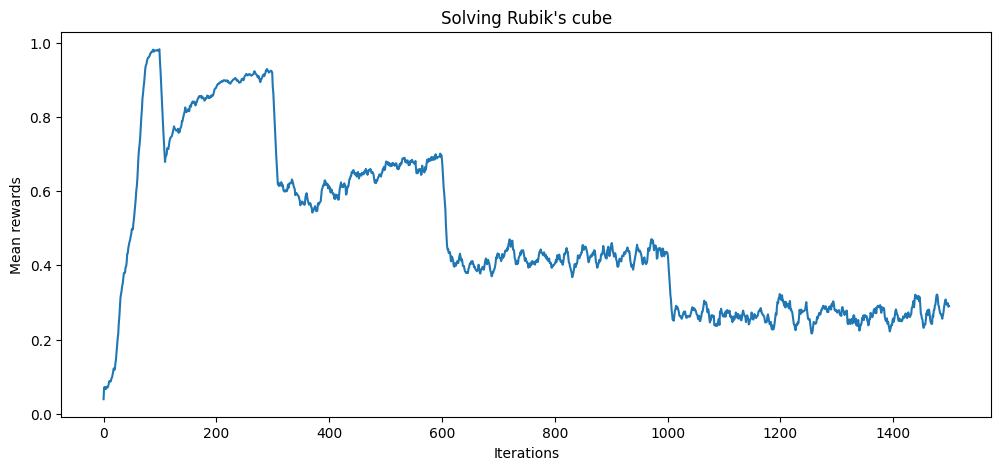

In [ ]:
plot_rewards(rewards_cl)

<Figure size 1600x800 with 0 Axes>

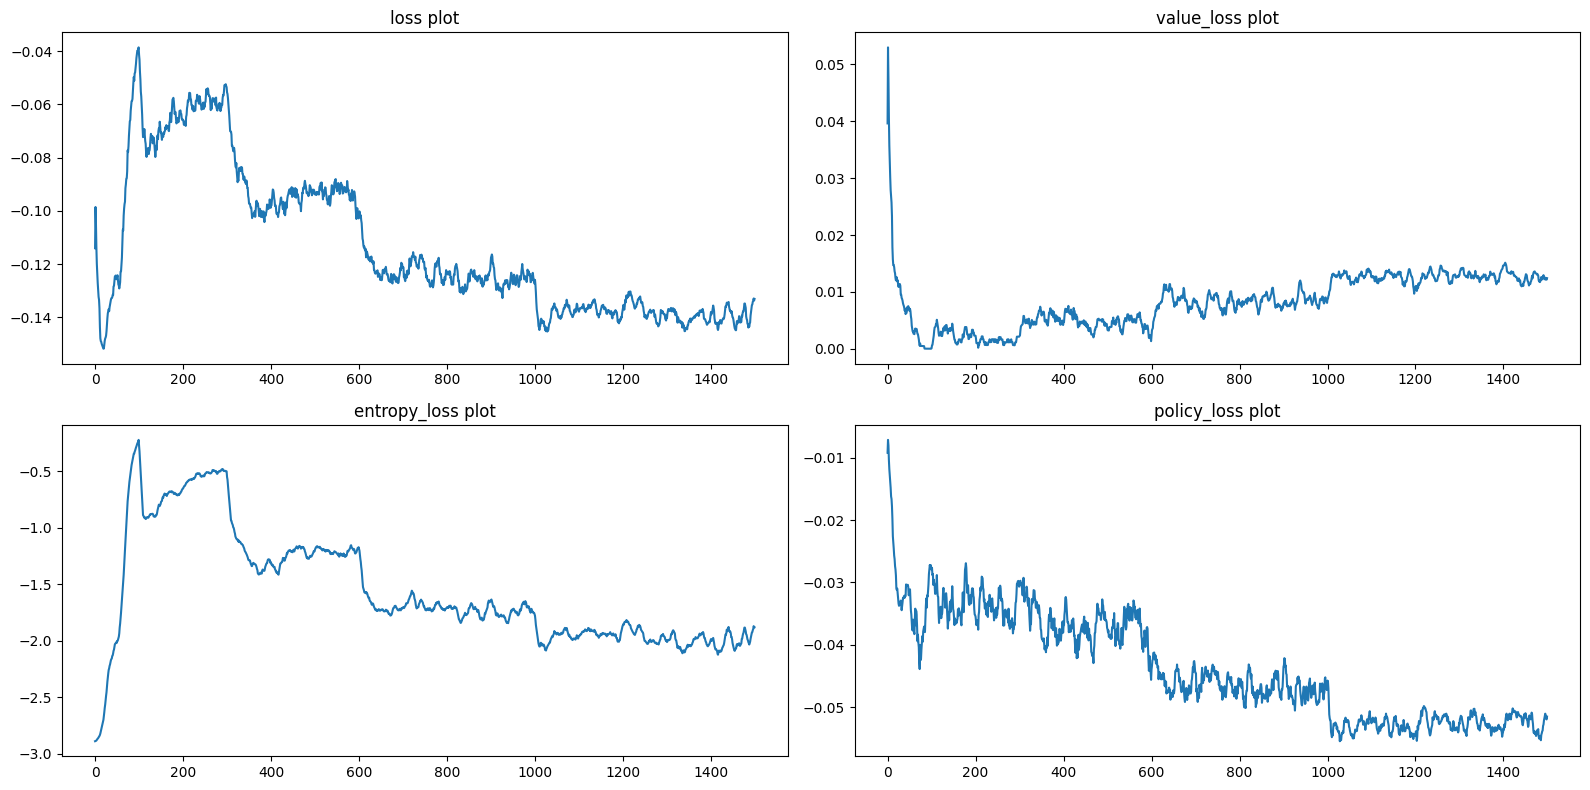

In [ ]:
plot_losses(losses_cl)

In [ ]:
print(trainer_cl._agent_state_factory)

<function _make_agent_state at 0x7864ab7d8e50>


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
